# I) **Importación de librerías y definición de funciones para graficar**

In [9]:
!pip install --upgrade tensorflow

In [10]:
!pip install scikeras

In [11]:
import pandas as pd
import numpy as np
import random
import math

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV

from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import mean_squared_error, log_loss, roc_curve, roc_auc_score, accuracy_score, recall_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', palette='deep', font_scale=1, rc={'grid.linestyle': '-'})

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [12]:
def metricas(nombre_modelo, y_test, y_prob):

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    # Predicciones umbral óptimo
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

    # Errores y métricas
    mse = mean_squared_error(y_test, y_prob)
    bce = log_loss(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred_optimal)
    rec = recall_score(y_test, y_pred_optimal)

    print(f'----- {nombre_modelo} -----')
    print(f'MSE: {mse:.4f}, BCE: {bce:.4f}, AUC: {auc:.4f}')
    print(f'Umbral óptimo de clasificación: {optimal_threshold:.4f}\n')
    print(classification_report(y_test, y_pred_optimal))

    return acc, rec, mse, bce, auc, fpr, tpr, optimal_threshold_index, optimal_threshold, y_pred_optimal

In [13]:
# Matriz de confusión
def matriz_confusion(y_test, y_pred_test, color='b'):

    cm = confusion_matrix(y_test, y_pred_test)
    cm_normalizada = cm.astype('float') / cm.sum(1)[:, np.newaxis]

    tn, fp, fn, tp = cm.ravel()
    print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n')

    plt.rcParams['figure.dpi'] = 75
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    colormap = colormap = sns.light_palette(color, 8)
    sns.heatmap(cm_normalizada, cmap=colormap, annot=True, annot_kws={'size': 16}, fmt='.2%', cbar=False)
    ax.set_xlabel('Valor predicho')
    ax.set_ylabel('Valor real')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)

    plt.show()

In [14]:
# Feature Importance
def feature_importance(modelo_importancia, color='b'):

    plt.rcParams['figure.dpi'] = 90
    plt.figure(figsize=(8, 5))

    sns.barplot(x='Importancia', y='Atributo', data=modelo_importancia, color=color)

    plt.title('Importancia de los atributos')
    plt.show()

In [15]:
url = 'https://raw.githubusercontent.com/pjr95/DiploDataScience/main/Churn_Modelling.csv'

churn = pd.read_csv(url)
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


# II) **Análisis Exploratorio**

In [16]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Se categoriza la variable `Credit_Score` tomando como referencia la puntuación FICO y se eliminan las características que no son relevantes para el análisis:

In [17]:
rangos = [349, 579, 699, 739, 799, 850]
scoring = ['Malo', 'Razonable', 'Bueno', 'Muy_Bueno', 'Excepcional'] # Puntuación FICO

churn_bank['Scoring'] = pd.cut(x=churn_bank['CreditScore'], bins=rangos, labels=scoring)
churn = churn_bank.drop(['RowNumber', 'CustomerId', 'Surname', 'CreditScore'], axis=1)
churn

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Scoring
0,France,Female,42,2,0.00,1,1,1,101348.88,1,Razonable
1,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Razonable
2,France,Female,42,8,159660.80,3,1,0,113931.57,1,Malo
3,France,Female,39,1,0.00,2,0,0,93826.63,0,Razonable
4,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Excepcional
...,...,...,...,...,...,...,...,...,...,...,...
9995,France,Male,39,5,0.00,2,1,0,96270.64,0,Muy_Bueno
9996,France,Male,35,10,57369.61,1,1,1,101699.77,0,Malo
9997,France,Female,36,7,0.00,1,0,1,42085.58,1,Bueno
9998,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,Muy_Bueno


In [18]:
churn.duplicated().sum()

0

In [19]:
churn.describe()

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


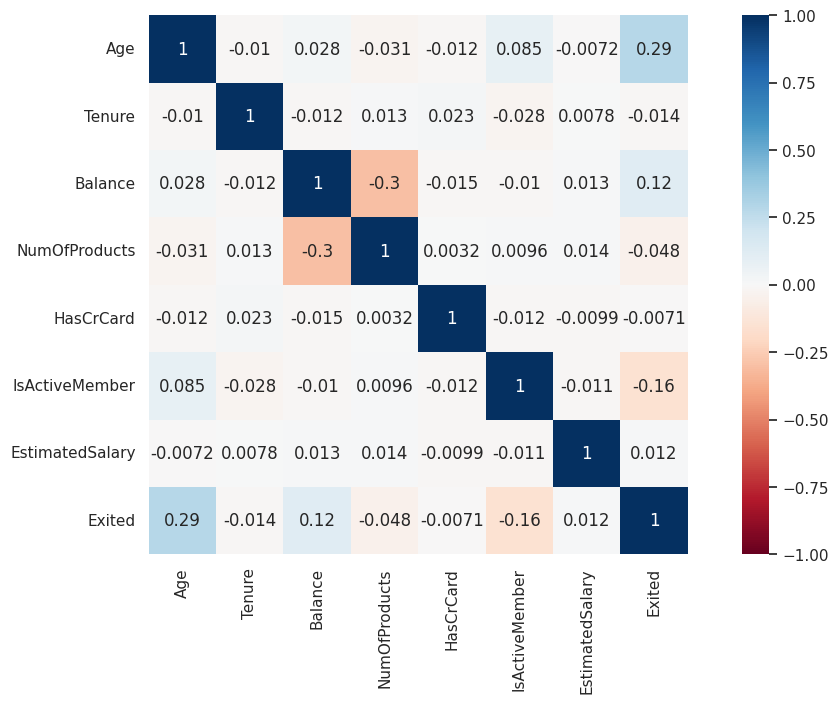

In [20]:
numericas = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

matriz_corr = churn[numericas].corr()
plt.figure(figsize=(14, 7))
sns.heatmap(matriz_corr, vmax=1, vmin=-1, square=True, annot=True, cmap='RdBu')
plt.show()

No existe una gran correlación lineal entre las variables, siendo las más correlacionadas Edad vs Exited (positiva) y NumOfProducts vs Balance (negativa).

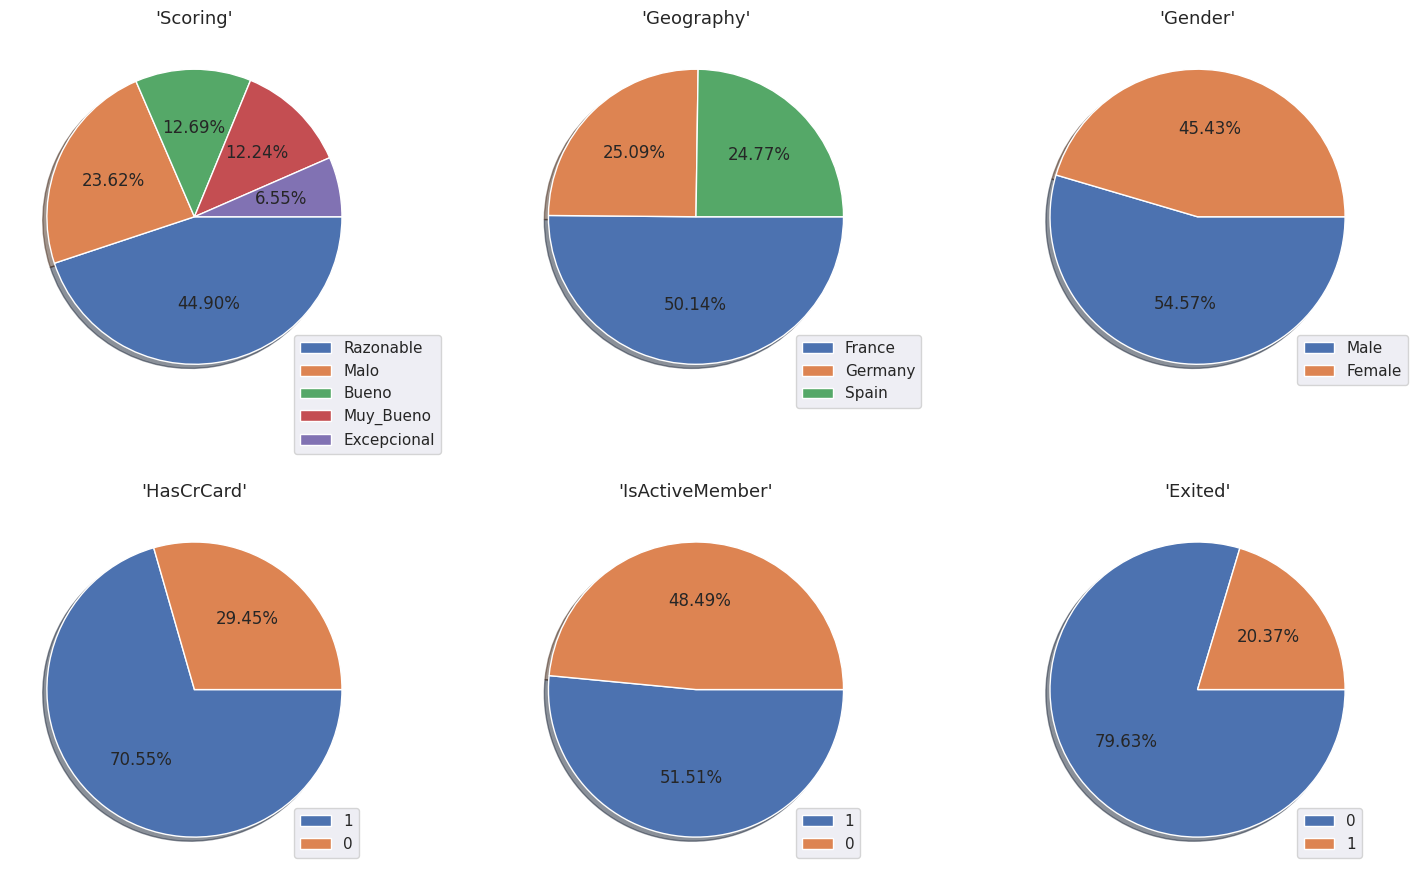

In [21]:
var_pie = ['Scoring', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
for i, pie in enumerate(var_pie):
    labels = churn[pie].value_counts().index.tolist()
    sizes = churn[pie].value_counts()
    row = i // 3
    col = i % 3
    axs[row, col].pie(sizes, autopct='%1.2f%%', counterclock=False, shadow=True, startangle=0)
    axs[row, col].legend(labels, bbox_to_anchor=(0.75, 0.2), frameon=True)
    axs[row, col].set_title(f"'{pie}'", fontsize=13, loc='center')

plt.tight_layout()
plt.show()

- Aproximadamente el 76% tienen un scoring positivo, es decir, se pueden considerar como 'no morosos' (están al día con sus deudas). Esto refleja una elevada proporción de morosidad.
- La mitad son franceses y la otra mitad se reparte 'a partes iguales' entre Alemania y España.
- Los registros son mayormente masculinos aunque la proporción está bastante equilibrada (55%-45%).
- El 71% tienen tarjeta de crédito, algo por debajo, por ejemplo, del caso de Argentina, donde el 74% de las personas tienen tarjetas de crédito. Esto va en consonancia con el hecho de que los europeos ven al efectivo como una forma de protección de su privacidad.
- La actividad bancaria de los registros observados es apenas del 52%, es decir, solo la mitad de estos utiliza recurrentemente su cuenta bancaria. (Podemos considerar, que una cuenta está inactiva luego de 6 meses sin movimientos en la misma, aunque esto depende de cada banco).
- La relación entre los miembros que no abandonaron el banco (0) y los que sí lo hicieron (1) es aprox 80%-20% en favor de los primeros, lo que evidencia un claro desbalanceo entre clases.

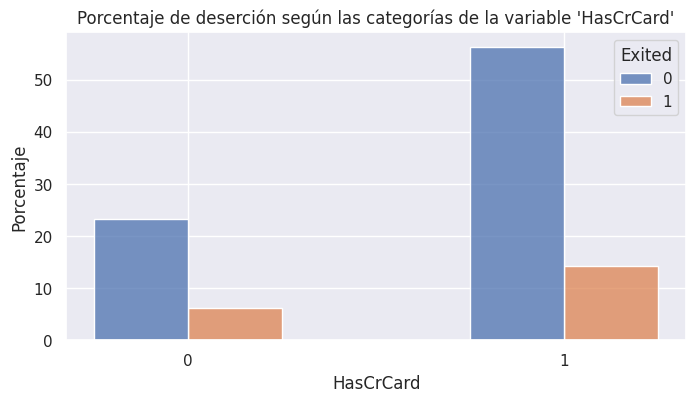

In [22]:
plt.figure(figsize=(8, 4))
plt.title("Porcentaje de deserción según las categorías de la variable 'HasCrCard'") #, palette= ['g', 'orange']
sns.histplot(data=churn, x='HasCrCard', hue='Exited', multiple='dodge', stat='percent', shrink=0.5, discrete=True)
valores_x = sorted(churn['HasCrCard'].unique())
plt.xticks(valores_x)
plt.ylabel('Porcentaje')
plt.show()

In [23]:
credit_exited = pd.crosstab(churn['HasCrCard'], churn['Exited'])
credit_exited

Exited,0,1
HasCrCard,,
0,2332,613
1,5631,1424


In [24]:
for i in range(2):
  for j in range(2):
    porcentaje = credit_exited.iloc[i, j]*100 / churn.shape[0]
    print('HasCrCard  Exited  Porcentaje')
    print(f'    {i}         {j}      {porcentaje}%')

HasCrCard  Exited  Porcentaje
    0         0      23.32%
HasCrCard  Exited  Porcentaje
    0         1      6.13%
HasCrCard  Exited  Porcentaje
    1         0      56.31%
HasCrCard  Exited  Porcentaje
    1         1      14.24%


La proporción de no abandono es unas 4 veces mayor al abandono tanto para los que tienen tarjeta de crédito como para los que no, es decir, no hay prácticamente diferencias en esta variable.

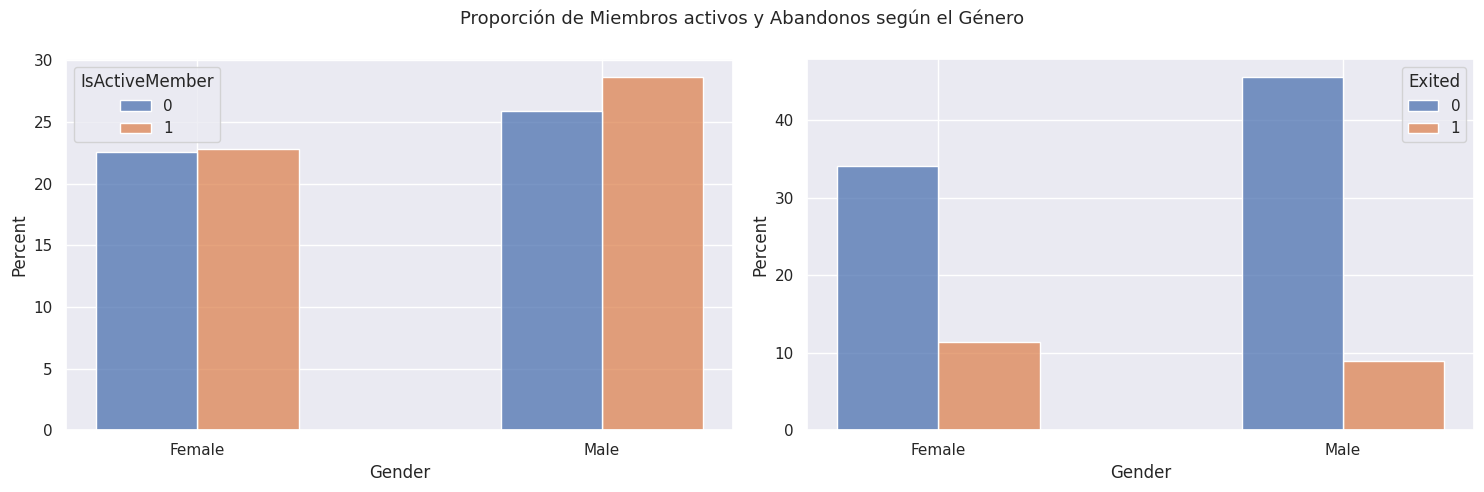

In [25]:
var_hue = ['IsActiveMember', 'Exited']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i, hue in enumerate(var_hue):
    # row = i // 2    # Hay UNA sola fila asique va directamente axs[i], sino va axs[row, col]
    # col = i % 2
    sns.histplot(data=churn, x='Gender', hue=hue, multiple='dodge', stat='percent', shrink=0.5, discrete=True, ax=axs[i])

plt.suptitle('Proporción de Miembros activos y Abandonos según el Género', fontsize=13, ha='center')
plt.tight_layout()
plt.show()

- Alrededor de la mitad de las mujeres son miembros inactivos del banco, en tanto que para los hombres existe una leve mayoría de miembros activos.
- Para el caso de los abandonos, del gráfico se puede observar que las mujeres tienden a abandonar más que los hombres, algo que puede corroborarse con la siguiente línea:

In [26]:
gender_exited = pd.crosstab(churn['Gender'], churn['Exited'])
for i in range(2):
  for j in range(2):
    porcentaje = gender_exited.iloc[i, j]*100 / churn.shape[0]
    print('Male  Exited  Porcentaje')
    print(f' {i}       {j}      {porcentaje}%')

Male  Exited  Porcentaje
 0       0      34.04%
Male  Exited  Porcentaje
 0       1      11.39%
Male  Exited  Porcentaje
 1       0      45.59%
Male  Exited  Porcentaje
 1       1      8.98%


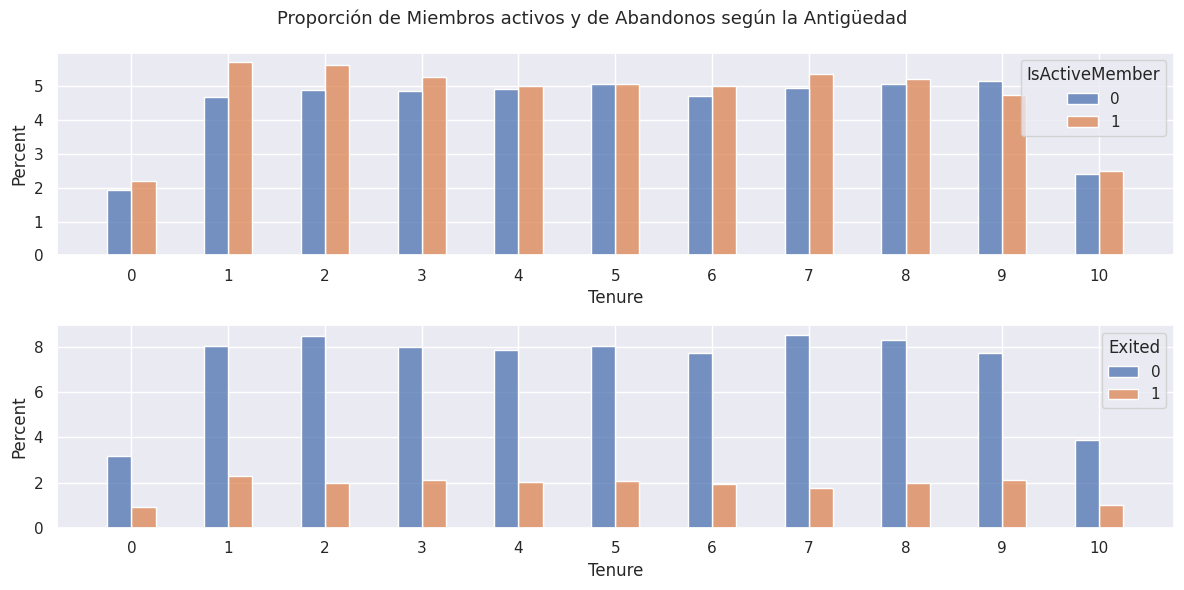

In [27]:
var_hue = ['IsActiveMember', 'Exited']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
for i, hue in enumerate(var_hue):
    sns.histplot(data=churn, x='Tenure', hue=hue, multiple='dodge', stat='percent', shrink=0.5, discrete=True, ax=axs[i])
    valores_x = sorted(churn['Tenure'].unique())
    axs[i].set_xticks(valores_x)

plt.suptitle('Proporción de Miembros activos y de Abandonos según la Antigüedad', fontsize=13, ha='center')
plt.tight_layout()
plt.show()

Notemos que el número de miembros en los años de antigüedad más extremos (1 año y 10 años) es mucho menor que en los años intermedios, donde la cantidad de registros es similar en todos los casos.
- La cantidad de miembros activos disminuye al aumentar la antigüedad, aunque se mantiene en torno al 4%-6% aprox.
- La proporción de miembros que abandonan el banco es similar en todos los años, lo cual es llamativo ya que uno tendería a pensar en una mayor tasa de deserción en los primeros años y una disminución de la misma con el paso del tiempo, debido a la fidelización de los miembros.

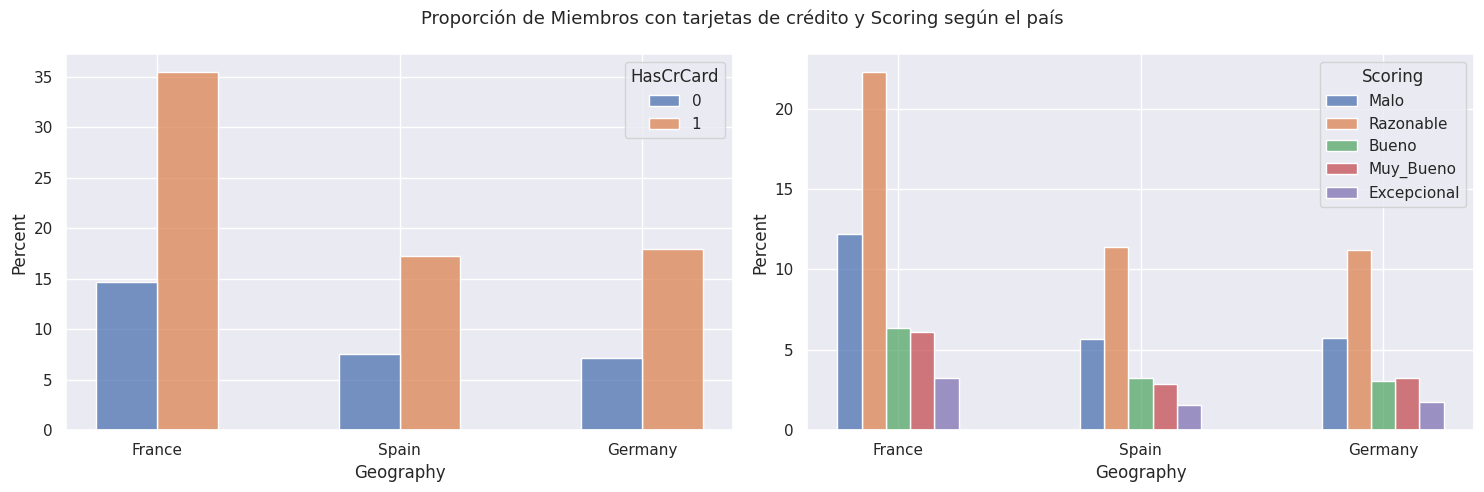

In [28]:
var_hue = ['HasCrCard', 'Scoring']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i, hue in enumerate(var_hue):
    sns.histplot(data=churn, x='Geography', hue=hue, multiple='dodge', stat='percent', shrink=0.5, discrete=True, ax=axs[i])

plt.suptitle('Proporción de Miembros con tarjetas de crédito y Scoring según el país', fontsize=13, ha='center')
plt.tight_layout()
plt.show()

- La cantidad de miembros con y sin tarjetas de créditos es aproximadamente el doble en Francia que en España y Alemania, estos últimos con porcentajes muy parecidos.
- Para el caso del Scoring crediticio es similar al primer gráfico, duplicando Francia el porcentaje de España y Alemania. Existe una mínima diferencia en la categoría 'Muy Bueno', siendo en España apenas menor que en Alemania.

El hecho de que España y Alemania tengan valores casi idénticos, ambos duplicados por Francia, es consecuente con el diagrama de torta de 'Geography' visto anteriormente. Que se mantenga la misma relación entre variables es un indicativo de la no multicolinealidad entre estas.

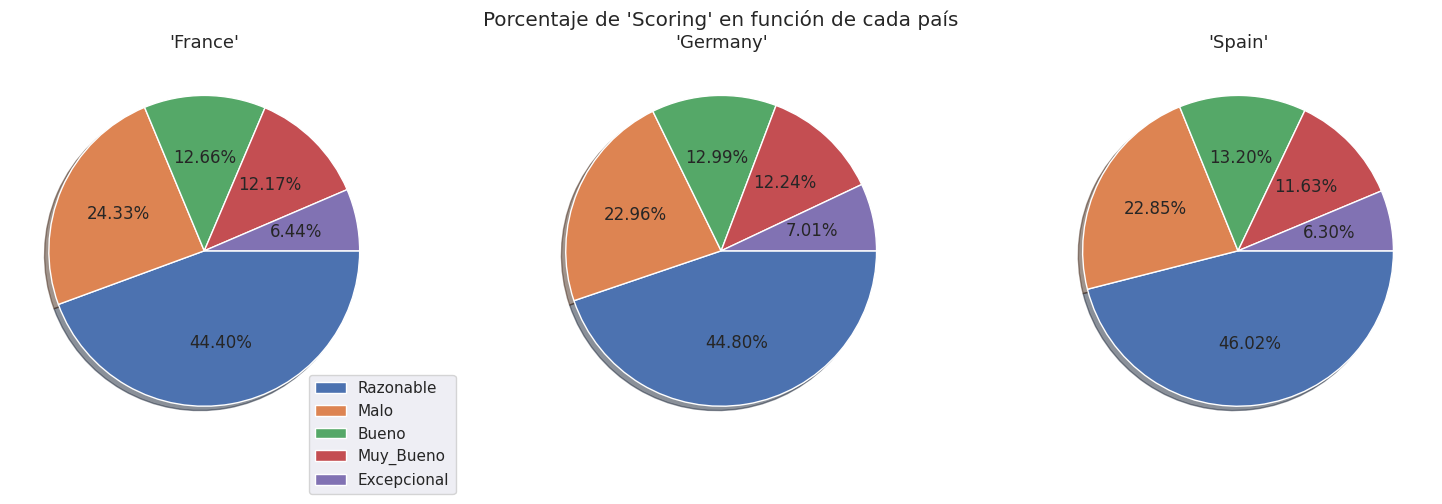

In [29]:
paises = churn['Geography'].value_counts().index.tolist()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, pais in enumerate(paises):
    labels = churn['Scoring'].value_counts().index.tolist()
    axs[i].pie(churn[churn['Geography'] == pais]['Scoring'].value_counts(), autopct='%1.2f%%', counterclock=False, shadow=True, startangle=0)
    axs[i].set_title(f"'{pais}'", fontsize=13, loc='center')
    axs[0].legend(labels, bbox_to_anchor=(0.75, 0.2), frameon=True)

plt.suptitle("Porcentaje de 'Scoring' en función de cada país", ha='center')
plt.tight_layout()
plt.show()

Al separar por país al diagrama de torta de CreditScore no se aprecia una diferencia significativa entre cada uno.

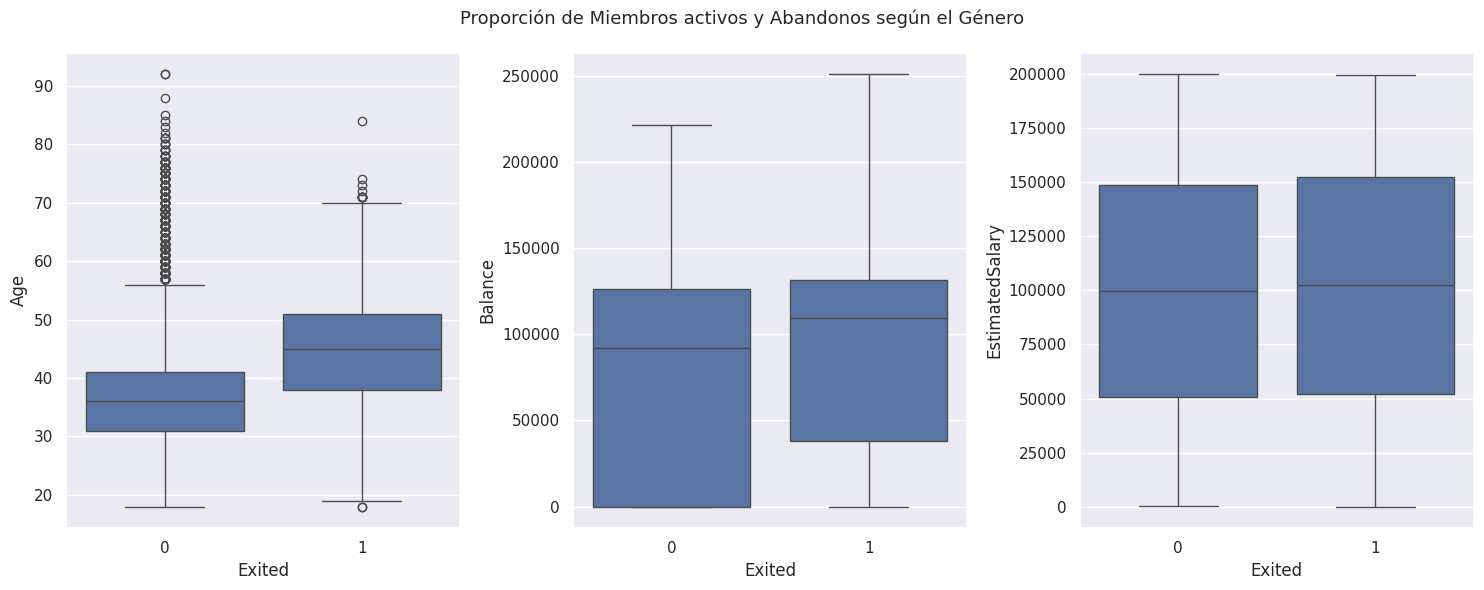

In [30]:
var_x = ['Age', 'Balance', 'EstimatedSalary']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
for i, x in enumerate(var_x):
    sns.boxplot(y=churn[x], x=churn['Exited'], ax=axs[i])

plt.suptitle('Proporción de Miembros activos y Abandonos según el Género', fontsize=13, ha='center')
plt.tight_layout()
plt.show()

- Las personas de mayor edad son más propensas al abandono.
- La gente con más dinero en la cuenta tiende a abandonar.
- El salario estimado no aporta información relevante al estudio.

# II) **Preprocesamiento de la base**

A continuación se separa la base en variables numéricas, binarias y categóricas y se dicotomizan estas últimas.

In [31]:
numericas = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
churn_numericas = churn[numericas]
churn_numericas

,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,42,2,0.00,1,101348.88
1,41,1,83807.86,1,112542.58
2,42,8,159660.80,3,113931.57
3,39,1,0.00,2,93826.63
4,43,2,125510.82,1,79084.10
...,...,...,...,...,...
9995,39,5,0.00,2,96270.64
9996,35,10,57369.61,1,101699.77
9997,36,7,0.00,1,42085.58
9998,42,3,75075.31,2,92888.52


In [32]:
binarias = ['HasCrCard', 'IsActiveMember', 'Exited']
churn_binarias = churn[binarias]
churn_binarias

,HasCrCard,IsActiveMember,Exited
0,1,1,1
1,0,1,0
2,1,0,1
3,0,0,0
4,1,1,0
...,...,...,...
9995,1,0,0
9996,1,1,0
9997,0,1,1
9998,1,0,1


In [33]:
categoricas = ['Geography', 'Gender', 'Scoring']
churn_categoricas = churn[categoricas]
churn_categoricas

,Geography,Gender,Scoring
0,France,Female,Razonable
1,Spain,Female,Razonable
2,France,Female,Malo
3,France,Female,Razonable
4,Spain,Female,Excepcional
...,...,...,...
9995,France,Male,Muy_Bueno
9996,France,Male,Malo
9997,France,Female,Bueno
9998,Germany,Male,Muy_Bueno


In [34]:
churn_categoricas = pd.get_dummies(churn_categoricas, drop_first=True, dtype=int)
churn_categoricas

,Geography_Germany,Geography_Spain,Gender_Male,Scoring_Razonable,Scoring_Bueno,Scoring_Muy_Bueno,Scoring_Excepcional
0,0,0,0,1,0,0,0
1,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...
9995,0,0,1,0,0,1,0
9996,0,0,1,0,0,0,0
9997,0,0,0,0,1,0,0
9998,1,0,1,0,0,1,0


In [35]:
churn_completo = pd.concat([churn_numericas, churn_categoricas], axis=1)
churn_completo = pd.concat([churn_completo, churn_binarias], axis=1)
churn_completo

,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Scoring_Razonable,Scoring_Bueno,Scoring_Muy_Bueno,Scoring_Excepcional,HasCrCard,IsActiveMember,Exited
0,42,2,0.00,1,101348.88,0,0,0,1,0,0,0,1,1,1
1,41,1,83807.86,1,112542.58,0,1,0,1,0,0,0,0,1,0
2,42,8,159660.80,3,113931.57,0,0,0,0,0,0,0,1,0,1
3,39,1,0.00,2,93826.63,0,0,0,1,0,0,0,0,0,0
4,43,2,125510.82,1,79084.10,0,1,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,39,5,0.00,2,96270.64,0,0,1,0,0,1,0,1,0,0
9996,35,10,57369.61,1,101699.77,0,0,1,0,0,0,0,1,1,0
9997,36,7,0.00,1,42085.58,0,0,0,0,1,0,0,0,1,1
9998,42,3,75075.31,2,92888.52,1,0,1,0,0,1,0,1,0,1


Para finalizar esta sección se separa la base en las variables independientes (X) de la variable objetivo (y), se divide en conjuntos de entrenamiento y validación y se estandarizan las exógenas.

In [36]:
X = churn_completo.drop('Exited', axis=1)
y = churn_completo['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

scaler = StandardScaler()
X_train[numericas] = scaler.fit_transform(X_train[numericas])
X_test[numericas] = scaler.transform(X_test[numericas])

# III) **Implementación de los modelos**

Recordar lo que ya se observó en el EDA acerca de las proporciones de cada clase:

In [37]:
# Dataset completo
clase_1 = churn_completo['Exited'].sum() / churn_completo.shape[0]
clase_0 = 1 - clase_1

clase_0, clase_1

(0.7963, 0.2037)

Para abordar esta problemática se ejecuta una Regresión Logística con desbalance y luego se aplican dos métodos de balanceo: $(i)$ submuestreo con `.sample` y $(ii)$ sobremuestreo con `SMOTE`. La técnica con mejor rendimiento es la que se utiliza en los restantes modelos.

In [38]:
# Conjunto de Entrenamiento
clase_1_train = y_train.sum() / y_train.shape[0]
clase_0_train = 1 - clase_1_train

clase_0_train, clase_1_train

(0.79625, 0.20375)

## **Regresión Logística**

### Clases DESBALANCEADAS (sin *tuning*)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


TN: 1541, FP: 52, FN: 331, TP: 76



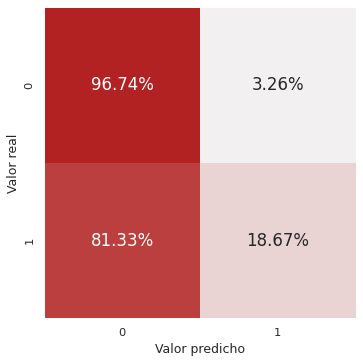

In [39]:
reg_log = LogisticRegression()
reg_log.fit(X_train, y_train)
y_pred_test = reg_log.predict(X_test)

print(classification_report(y_test, y_pred_test))
print('')
matriz_confusion(y_test, y_pred_test, color='firebrick')

El modelo asigna todos los registros a la clase mayoritaria como era de esperar.

### Clases BALANCEADAS usando **sobremuestreo** 50-50 (sin *tuning*)

In [40]:
smote = SMOTE(sampling_strategy='minority', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

proporcion_original_y = Counter(y_train)
proporcion_equilibrado_y = Counter(y_resampled)
print("Proporción de clases en el conjunto de datos  original  :", proporcion_original_y)
print("Proporción de clases en el conjunto de datos equilibrado:", proporcion_equilibrado_y)

Proporción de clases en el conjunto de datos  original  : Counter({0: 6370, 1: 1630})
Proporción de clases en el conjunto de datos equilibrado: Counter({1: 6370, 0: 6370})


In [41]:
churn_smote = pd.concat([X_resampled, y_resampled], axis=1)
churn_smote

,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Scoring_Razonable,Scoring_Bueno,Scoring_Muy_Bueno,Scoring_Excepcional,HasCrCard,IsActiveMember,Exited
0,1.715086,0.684723,-1.226059,-0.910256,1.042084,0,0,1,0,0,1,0,1,0,1
1,-0.659935,-0.696202,0.413288,-0.910256,-0.623556,1,0,1,0,1,0,0,1,0,1
2,-0.184931,-1.731895,0.601687,0.808830,0.308128,1,0,0,0,0,1,0,1,1,0
3,-0.184931,-0.005739,-1.226059,0.808830,-0.290199,0,0,1,0,0,0,0,1,0,0
4,0.955079,0.339492,0.548318,0.808830,0.135042,1,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12735,0.005071,1.332901,0.963297,-0.910256,0.334354,1,0,0,1,0,0,0,1,1,1
12736,1.784220,-0.327470,0.545712,0.808830,0.707718,0,1,0,0,0,0,0,1,0,1
12737,0.624272,-1.345051,-1.226059,-0.910256,0.249588,0,0,0,0,0,0,0,1,1,1
12738,0.899031,-0.209418,0.637249,-0.910256,0.176043,1,0,0,0,0,0,0,1,0,1


In [42]:
X_train_smote = churn_smote.drop('Exited', axis=1)
y_train_smote = churn_smote['Exited']

              precision    recall  f1-score   support

           0       0.89      0.73      0.81      1593
           1       0.39      0.65      0.49       407

    accuracy                           0.72      2000
   macro avg       0.64      0.69      0.65      2000
weighted avg       0.79      0.72      0.74      2000


TN: 1170, FP: 423, FN: 141, TP: 266



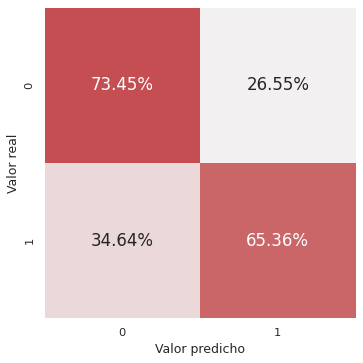

In [43]:
reg_log = LogisticRegression()
reg_log.fit(X_train_smote, y_train_smote)
y_pred_test = reg_log.predict(X_test)

print(classification_report(y_test, y_pred_test))
print('')
matriz_confusion(y_test, y_pred_test, color='r')

### Clases BALANCEADAS usando **submuestreo** 50-50 (sin *tuning*)

In [44]:
churn_train = pd.concat([X_train, y_train], axis=1)
churn_train

,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Scoring_Razonable,Scoring_Bueno,Scoring_Muy_Bueno,Scoring_Excepcional,HasCrCard,IsActiveMember,Exited
2151,1.715086,0.684723,-1.226059,-0.910256,1.042084,0,0,1,0,0,1,0,1,0,1
8392,-0.659935,-0.696202,0.413288,-0.910256,-0.623556,1,0,1,0,1,0,0,1,0,1
5006,-0.184931,-1.731895,0.601687,0.808830,0.308128,1,0,0,0,0,1,0,1,1,0
4117,-0.184931,-0.005739,-1.226059,0.808830,-0.290199,0,0,1,0,0,0,0,1,0,0
7182,0.955079,0.339492,0.548318,0.808830,0.135042,1,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,-0.374933,0.339492,-1.226059,-0.910256,-1.294966,0,1,0,1,0,0,0,1,0,1
4644,3.330101,-0.005739,-1.226059,0.808830,0.901685,0,1,1,0,1,0,0,0,0,0
8942,-0.184931,1.375185,-0.073747,0.808830,-0.558088,0,0,0,1,0,0,0,1,1,0
2935,-0.374933,1.029954,0.394991,0.808830,-1.351500,0,1,1,1,0,0,0,1,0,0


In [45]:
clase_may = churn_train[churn_train['Exited'] == 0]
clase_min = churn_train[churn_train['Exited'] == 1]

clase_may_sample = clase_may.sample(n=1630, random_state=42)

churn_balanceado = pd.concat([clase_may_sample, clase_min])
churn_balanceado

,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Scoring_Razonable,Scoring_Bueno,Scoring_Muy_Bueno,Scoring_Excepcional,HasCrCard,IsActiveMember,Exited
6949,-0.184931,-1.041433,0.373670,0.808830,0.836712,1,0,1,0,0,1,0,0,1,0
8587,0.195072,-1.041433,0.882213,0.808830,-1.616839,1,0,1,1,0,0,0,0,1,0
5730,-0.944938,-0.350971,-1.226059,0.808830,0.020728,0,0,0,0,0,0,0,1,1,0
7011,-1.324942,-1.386664,-1.226059,0.808830,-0.208044,0,0,0,1,0,0,0,0,0,0
7788,3.520103,-1.041433,0.835169,0.808830,1.430067,0,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,0.195072,-0.350971,1.004141,-0.910256,0.032911,0,0,1,1,0,0,0,1,1,1
6821,0.005071,0.684723,0.702505,0.808830,-0.701774,0,0,0,0,0,0,1,0,1,1
127,1.620086,-1.731895,1.157755,-0.910256,-0.922821,1,0,1,1,0,0,0,1,0,1
487,0.005071,-0.696202,0.942493,-0.910256,-1.489187,0,0,1,0,0,0,0,1,1,1


In [46]:
X_train_bal = churn_balanceado.drop('Exited', axis=1)
y_train_bal = churn_balanceado['Exited']

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.72      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.73      2000


TN: 1120, FP: 473, FN: 112, TP: 295



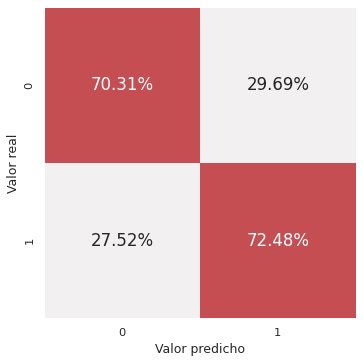

In [47]:
reg_log = LogisticRegression()
reg_log.fit(X_train_bal, y_train_bal)
y_pred_test = reg_log.predict(X_test)

print(classification_report(y_test, y_pred_test))
print('')
matriz_confusion(y_test, y_pred_test, color='r')

### *Tuning* de hiperparámetros, curva ROC, probabilidad de pertenencia y umbral de decisión

Se observa que el sobremuestreo no mejora los resultados del submuestreo, por lo que la segunda técnica es la utilizada en adelante. En este apartado se hace una búsqueda de los hiperparámetros óptimos y, por medio de la curva ROC, se busca el punto de corte que optimiza la separación de las clases.

In [48]:
# Recordar que X_train_bal, y_train_bal ya están separados y contienen el subsampleo

param_dist_rl = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'C': np.logspace(-3, 3, 7)
}

reg_log = LogisticRegression(random_state=42)
grid_search_rl = GridSearchCV(reg_log, param_grid=param_dist_rl, cv=10, scoring='accuracy') # anda mejor que 'recall'
grid_search_rl.fit(X_train_bal, y_train_bal)

best_reg_log = grid_search_rl.best_estimator_
best_params_rl = grid_search_rl.best_params_
best_score_rl = grid_search_rl.best_score_

best_reg_log.fit(X_train_bal, y_train_bal)
y_prob_rl = best_reg_log.predict_proba(X_test)[:,1]

print(f'--- Regresión Logística (tuning) ---')
print(f'Mejor modelo: {best_reg_log}')
print(f'Mejores hiperparámetros: {best_params_rl}')
print(f'Puntuación de estos hiperparámetros: {best_score_rl}')

--- Regresión Logística (tuning) ---
Mejor modelo: LogisticRegression(C=0.01, random_state=42, solver='liblinear')
Mejores hiperparámetros: {'C': 0.01, 'solver': 'liblinear'}
Puntuación de estos hiperparámetros: 0.7085889570552146


----- Regresión Logística -----
MSE: 0.1971, BCE: 0.5824, AUC: 0.7765
Umbral óptimo de clasificación: 0.4927

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1593
           1       0.39      0.73      0.51       407

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.71      0.74      2000

Mejores hiperparámetros: {'C': 0.01, 'solver': 'liblinear'}

TN: 1132, FP: 461, FN: 110, TP: 297



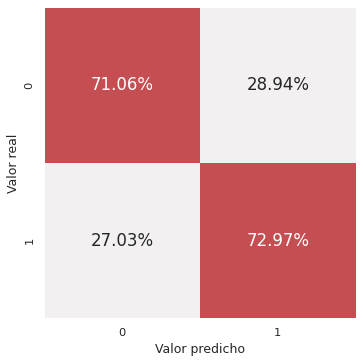

In [49]:
acc_rl, rec_rl, mse_rl, bce_rl, auc_rl, fpr_rl, tpr_rl, optimal_threshold_index_rl, optimal_threshold_rl, y_pred_optimal_rl = metricas('Regresión Logística', y_test, y_prob_rl)
print(f'Mejores hiperparámetros: {best_params_rl}\n')
matriz_confusion(y_test, y_pred_optimal_rl, color='r')

La búsqueda de hiperparámetros efectivamente mejora al modelo respecto al análogo sin *tuning*.

Por otra parte, se pueden obtener los coeficientes del vector de pesos y bias, los cuales son:

In [50]:
best_reg_log.coef_, best_reg_log.intercept_

(array([[ 0.66318724,  0.00381064,  0.20915304, -0.04882164,  0.05571363,
          0.48977157, -0.01873712, -0.36457085,  0.00850448, -0.06851945,
         -0.02574553, -0.0398015 ,  0.00957729, -0.55038278]]),
 array([0.14249364]))

Aquellos con mayor relevancia dentro del modelo son los más alejados del cero (tanto >0 como <0). Si se grafican ordenadamente:

In [51]:
importancia = np.abs(best_reg_log.coef_[0]) / np.sum(np.abs(best_reg_log.coef_[0])) # normalización
np.sort(importancia)[::-1]
indices = np.argsort(importancia)[::-1]           # ver cuáles son los índices de los valores anteriores

importancia = importancia[indices]
nombres = np.array(X_train_bal.columns)[indices]  # nombres de cada variable ordenada

               Atributo  Importancia
0                   Age     0.259433
1        IsActiveMember     0.215305
2     Geography_Germany     0.191594
3           Gender_Male     0.142617
4               Balance     0.081819
5         Scoring_Bueno     0.026804
6       EstimatedSalary     0.021795
7         NumOfProducts     0.019099
8   Scoring_Excepcional     0.015570
9     Scoring_Muy_Bueno     0.010071
10      Geography_Spain     0.007330
11            HasCrCard     0.003747
12    Scoring_Razonable     0.003327
13               Tenure     0.001491



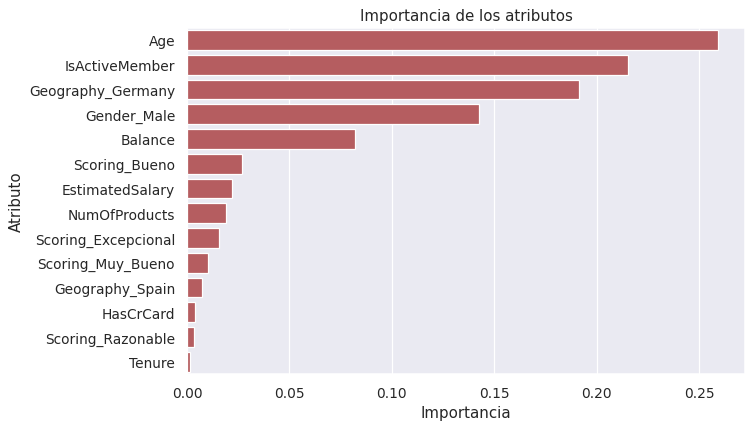

In [52]:
reg_log_importancia = pd.DataFrame({'Atributo': nombres, 'Importancia': importancia})
reg_log_importancia = reg_log_importancia.sort_values(by='Importancia', ascending=False)

print(reg_log_importancia)
print('')
feature_importance(reg_log_importancia, color='r')

Tomando, por ejemplo, el 1% como límite, se puede incluir hasta `Scoring_Muy_Bueno`, descartando 4 variables de las 14 totales (una reducción del 29%). Sin embargo, no se adopta este enfoque para hacer *feature selection* ya que es esperable que cada modelo asigne de distinta manera la importancia de los atributos, teniendo que realizar un análisis similar para cada algoritmo; haciéndolo ineficiente tanto en tiempo como en costo computacional.

Por este motivo, la selección de atributos se realiza en la próxima sección con Random Forest, donde la elección se realiza mediante la ganancia de información, la cual es independiente del modelo *per sé* (también se podría usar un híbrido entre los dos métodos y/o incluir otros como la *permutation importance* o la matriz de correlación aunque no se implementan aquí).

## **Random Forest**

Recordar que a partir de ahora solo se usa la base submuestreada (`churn_balanceado`), que fue la que mejores resultados obtuvo en la regresión logística. Además se aplican directamente la búsqueda de hiperparámetros, umbrales, etc.

In [53]:
param_dist_rf = {
    'n_estimators': np.arange(10, 201, 10),
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(5, 31, 5),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5)
    }

rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=50, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train_bal, y_train_bal)

best_ran_for = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_

best_ran_for.fit(X_train_bal, y_train_bal)
y_prob_rf = best_ran_for.predict_proba(X_test)[:,1]

----- Random Forest -----
MSE: 0.1566, BCE: 0.4809, AUC: 0.8587
Umbral óptimo de clasificación: 0.5103

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1593
           1       0.49      0.76      0.60       407

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.81      2000

Mejores hiperparámetros: {'n_estimators': 130, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 25, 'criterion': 'gini'}

TN: 1277, FP: 316, FN: 99, TP: 308



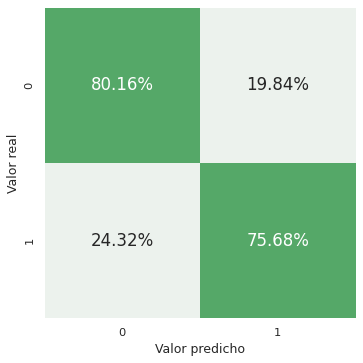

In [54]:
acc_rf, rec_rf, mse_rf, bce_rf, auc_rf, fpr_rf, tpr_rf, optimal_threshold_index_rf, optimal_threshold_rf, y_pred_optimal_rf = metricas('Random Forest', y_test, y_prob_rf)
print(f'Mejores hiperparámetros: {best_params_rf}\n')
matriz_confusion(y_test, y_pred_optimal_rf, color='g')

Similar al modelo anterior, se puede ver la importancia de cada una de las características según la ganancia de información:

               Atributo  Importancia
0                   Age     0.313005
3         NumOfProducts     0.142467
2               Balance     0.138139
4       EstimatedSalary     0.122632
1                Tenure     0.074974
13       IsActiveMember     0.054113
5     Geography_Germany     0.046017
7           Gender_Male     0.030452
12            HasCrCard     0.018137
8     Scoring_Razonable     0.017411
6       Geography_Spain     0.014479
9         Scoring_Bueno     0.011006
10    Scoring_Muy_Bueno     0.010841
11  Scoring_Excepcional     0.006326



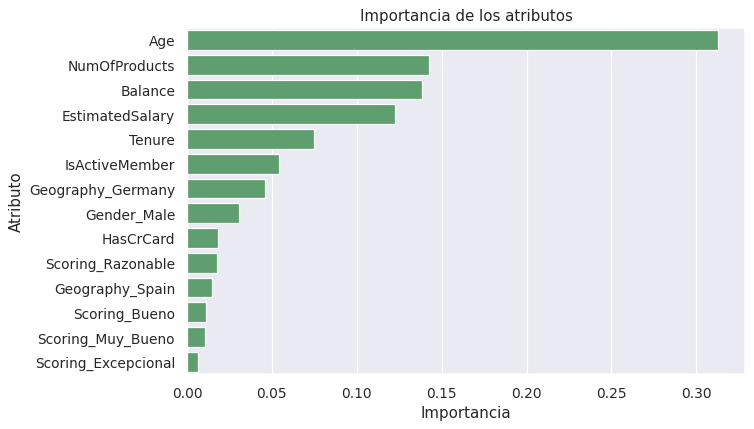

In [55]:
importancias = best_ran_for.feature_importances_

rf_importancia = pd.DataFrame({'Atributo': X_train_bal.columns, 'Importancia': importancias})
rf_importancia = rf_importancia.sort_values(by='Importancia', ascending=False)

print(rf_importancia)
print('')
feature_importance(rf_importancia, color='g')

Notar que `Age` sigue siendo la variable más importante aunque otras como `NumberOfProducts`, la segunda con mayor relevancia, tiene un impacto mucho menor en el modelo anterior. Esto evidencia las diferencias entre los enfoques sobre cómo abordar el mismo problema.

En este caso, si se sigue con el criterio del 1% se puede descartar las última variable y reajustar el modelo. No obstante, dado que deriva de la dicotomización de `Scoring`, no será eliminada para evitar suprimir información de la variable original. (De nuevo recalcar que se podría hacer un análisis más exhaustivo sobre importancia de atributos con diferentes metodologías. Esto no es lo que se realiza en este trabajo y solo queda el apartado a modo de comentario).

## **XGBoost**

In [56]:
param_dist_xgb = {
    'n_estimators': np.arange(10, 201, 10),
    'max_depth': np.arange(5, 16, 5),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.arange(0.5, 1.0, 1),
    'gamma': np.arange(0, 0.5, 0.1),
    'min_child_weight': np.arange(1, 11, 1)
}

xgb = XGBClassifier(scale_pos_weight=1, random_state=42)
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=50, cv=5, scoring='recall_macro', random_state=42)
random_search_xgb.fit(X_train_bal, y_train_bal)

best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_

best_xgb.fit(X_train_bal, y_train_bal)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

----- XGBoost -----
MSE: 0.1505, BCE: 0.4642, AUC: 0.8621
Umbral óptimo de clasificación: 0.4593

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1593
           1       0.45      0.81      0.58       407

    accuracy                           0.76      2000
   macro avg       0.69      0.78      0.71      2000
weighted avg       0.84      0.76      0.78      2000

Mejores hiperparámetros: {'subsample': 0.5, 'n_estimators': 30, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1711111111111111, 'gamma': 0.30000000000000004}

TN: 1195, FP: 398, FN: 79, TP: 328



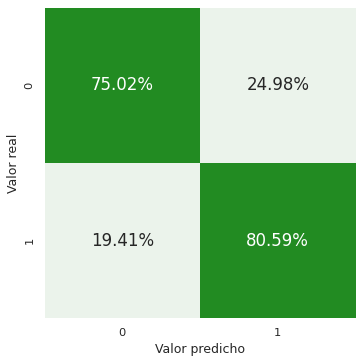

In [57]:
acc_xgb, rec_xgb, mse_xgb, bce_xgb, auc_xgb, fpr_xgb, tpr_xgb, optimal_threshold_index_xgb, optimal_threshold_xgb, y_pred_optimal_xgb = metricas('XGBoost', y_test, y_prob_xgb)
print(f'Mejores hiperparámetros: {best_params_xgb}\n')
matriz_confusion(y_test, y_pred_optimal_xgb, color='forestgreen')

## **Perceptron**

In [58]:
param_grid_perc = {
    'penalty': ['l1', 'l2'],
    'alpha': np.logspace(-3, 0, 3),
    'max_iter': np.arange(100, 1001, 100),
    'tol': [1e-4, 1e-3, 1e-2]
}

perceptron = Perceptron(random_state=42)
grid_search_perc = GridSearchCV(perceptron, param_grid=param_grid_perc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_perc.fit(X_train_bal, y_train_bal)

best_perceptron = grid_search_perc.best_estimator_
best_params_perc = grid_search_perc.best_params_
best_score_perc = grid_search_perc.best_score_

cc_perceptron = CalibratedClassifierCV(best_perceptron) # calibrar para obtener probabilidades
cc_perceptron.fit(X_train_bal, y_train_bal)
y_prob_perc = cc_perceptron.predict_proba(X_test)[:, 1]

----- Perceptron -----
MSE: 0.2049, BCE: 0.5993, AUC: 0.7715
Umbral óptimo de clasificación: 0.4949

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.72      0.50       407

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000

Mejores hiperparámetros: {'alpha': 0.001, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}

TN: 1114, FP: 479, FN: 112, TP: 295



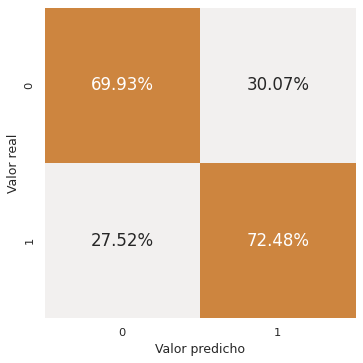

In [59]:
acc_perc, rec_perc, mse_perc, bce_perc, auc_perc, fpr_perc, tpr_perc, optimal_threshold_index_perc, optimal_threshold_perc, y_pred_optimal_perc = metricas('Perceptron', y_test, y_prob_perc)
print(f'Mejores hiperparámetros: {best_params_perc}\n')
matriz_confusion(y_test, y_pred_optimal_perc, color='peru')

## **LinearSVC**

In [60]:
param_grid_lsvc = [
      {'penalty': ['l1'], 'C': np.logspace(-3, 3, 7), 'dual': [False]},  # l1 no anda con True
      {'penalty': ['l2'], 'C': np.logspace(-3, 3, 7), 'dual': [True, False]}
]

linear_svc = LinearSVC(random_state=42)
grid_search_lsvc = GridSearchCV(linear_svc, param_grid=param_grid_lsvc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lsvc.fit(X_train_bal, y_train_bal)

best_linear_svc = grid_search_lsvc.best_estimator_
best_params_lsvc = grid_search_lsvc.best_params_
best_score_lsvc = grid_search_lsvc.best_score_

cc_linear_svc = CalibratedClassifierCV(best_linear_svc)
cc_linear_svc.fit(X_train_bal, y_train_bal)
y_prob_lsvc = cc_linear_svc.predict_proba(X_test)[:, 1]

----- Linear SVC -----
MSE: 0.1958, BCE: 0.5810, AUC: 0.7791
Umbral óptimo de clasificación: 0.5015

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1593
           1       0.40      0.73      0.52       407

    accuracy                           0.72      2000
   macro avg       0.66      0.73      0.66      2000
weighted avg       0.81      0.72      0.75      2000

Mejores hiperparámetros: {'C': 0.01, 'dual': False, 'penalty': 'l1'}

TN: 1152, FP: 441, FN: 109, TP: 298



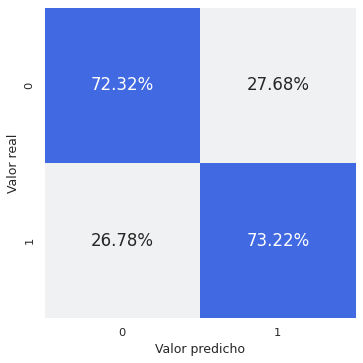

In [61]:
acc_lsvc, rec_lsvc, mse_lsvc, bce_lsvc, auc_lsvc, fpr_lsvc, tpr_lsvc, optimal_threshold_index_lsvc, optimal_threshold_lsvc, y_pred_optimal_lsvc = metricas('Linear SVC', y_test, y_prob_lsvc)
print(f'Mejores hiperparámetros: {best_params_lsvc}\n')
matriz_confusion(y_test, y_pred_optimal_lsvc, color='royalblue')

## **SVC** (kernel gaussiano)

In [62]:
param_grid_rbf = {
    'C': np.logspace(-2, 2, 5),
    'gamma': np.logspace(-2, 2, 5)
}

svc_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
grid_search_rbf = GridSearchCV(svc_rbf, param_grid=param_grid_rbf, cv=5, scoring='recall_macro', n_jobs=-1)
grid_search_rbf.fit(X_train_bal, y_train_bal)

best_params_rbf = grid_search_rbf.best_params_
best_score_rbf = grid_search_rbf.best_score_
best_svc_rbf = SVC(kernel='rbf', probability=True, random_state=42, **best_params_rbf)

best_svc_rbf.fit(X_train_bal, y_train_bal)
y_prob_rbf = best_svc_rbf.predict_proba(X_test)[:,1]

----- SVC Gaussiano -----
MSE: 0.1566, BCE: 0.4806, AUC: 0.8494
Umbral óptimo de clasificación: 0.6486

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.58      0.66      0.62       407

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.76      2000
weighted avg       0.84      0.83      0.84      2000

Mejores hiperparámetros: {'C': 10.0, 'gamma': 0.1}

TN: 1399, FP: 194, FN: 139, TP: 268



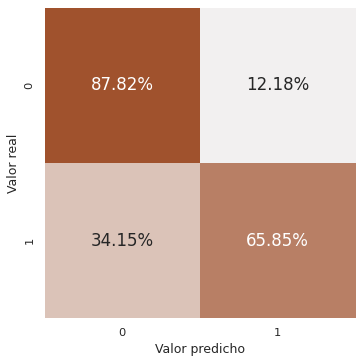

In [63]:
acc_rbf, rec_rbf, mse_rbf, bce_rbf, auc_rbf, fpr_rbf, tpr_rbf, optimal_threshold_index_rbf, optimal_threshold_rbf, y_pred_optimal_rbf = metricas('SVC Gaussiano', y_test, y_prob_rbf)
print(f'Mejores hiperparámetros: {best_params_rbf}\n')
matriz_confusion(y_test, y_pred_optimal_rbf, color='sienna')

## **Red feedforward** (Keras)

In [64]:
def feedforward(dropout_rate=0.2, learning_rate=0.001, optimizer='adam'):
    ffnn = Sequential()
    ffnn.add(Dense(units=50, activation='relu', input_shape=(X_train_bal.shape[1],)))
    ffnn.add(Dropout(dropout_rate))
    ffnn.add(Dense(units=50, activation='relu'))
    ffnn.add(Dropout(dropout_rate))
    ffnn.add(Dense(1, activation='sigmoid'))
    ffnn.compile(loss='bce', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    # ffnn.summary()
    return ffnn

In [65]:
param_dist_ffnn = {
    'dropout_rate': [0.0, 0.2, 0.4],
    'learning_rate': [0.0001, 0.001, 0.01]
}

ffnn_keras = KerasClassifier(model=feedforward, epochs=10, batch_size=64, verbose=2, dropout_rate=0.2, learning_rate=0.001, random_state=42)
random_search_keras = RandomizedSearchCV(estimator=ffnn_keras, param_distributions=param_dist_ffnn, scoring='recall', cv=5, random_state=42)
random_search_keras.fit(X_train_bal, y_train_bal, batch_size=64)

best_keras = random_search_keras.best_estimator_
best_params_keras = random_search_keras.best_params_
best_Score_keras = random_search_keras.best_score_

# best_keras.fit(X_train_bal, y_train_bal)
history = best_keras.fit(X_train_bal, y_train_bal, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(patience=5, monitor='val_loss', mode='min')])

y_prob_keras = best_keras.predict_proba(X_test)[:,1]

Epoch 1/10
41/41 - 1s - 31ms/step - loss: 0.6936
Epoch 2/10
41/41 - 0s - 2ms/step - loss: 0.6802
Epoch 3/10
41/41 - 0s - 2ms/step - loss: 0.6679
Epoch 4/10
41/41 - 0s - 3ms/step - loss: 0.6561
Epoch 5/10
41/41 - 0s - 3ms/step - loss: 0.6447
Epoch 6/10
41/41 - 0s - 3ms/step - loss: 0.6335
Epoch 7/10
41/41 - 0s - 2ms/step - loss: 0.6227
Epoch 8/10
41/41 - 0s - 2ms/step - loss: 0.6122
Epoch 9/10
41/41 - 0s - 3ms/step - loss: 0.6021
Epoch 10/10
41/41 - 0s - 2ms/step - loss: 0.5925
11/11 - 0s - 11ms/step
Epoch 1/10
41/41 - 1s - 27ms/step - loss: 0.6934
Epoch 2/10
41/41 - 0s - 3ms/step - loss: 0.6790
Epoch 3/10
41/41 - 0s - 2ms/step - loss: 0.6659
Epoch 4/10
41/41 - 0s - 3ms/step - loss: 0.6533
Epoch 5/10
41/41 - 0s - 2ms/step - loss: 0.6412
Epoch 6/10
41/41 - 0s - 3ms/step - loss: 0.6293
Epoch 7/10
41/41 - 0s - 2ms/step - loss: 0.6177
Epoch 8/10
41/41 - 0s - 2ms/step - loss: 0.6065
Epoch 9/10
41/41 - 0s - 4ms/step - loss: 0.5958
Epoch 10/10
41/41 - 0s - 3ms/step - loss: 0.5858
11/11 - 0s - 

----- Red feedforward (Keras) -----
MSE: 0.1572, BCE: 0.4783, AUC: 0.8581
Umbral óptimo de clasificación: 0.5275

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1593
           1       0.50      0.76      0.60       407

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.81      2000

Mejores hiperparámetros: {'learning_rate': 0.001, 'dropout_rate': 0.4}

TN: 1281, FP: 312, FN: 99, TP: 308



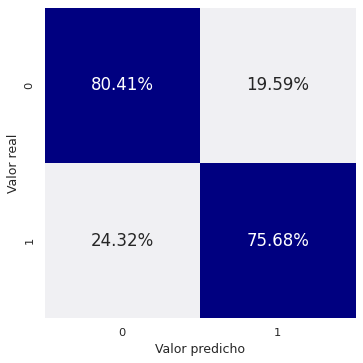

In [66]:
acc_keras, rec_keras, mse_keras, bce_keras, auc_keras, fpr_keras, tpr_keras, optimal_threshold_index_keras, optimal_threshold_keras, y_pred_optimal_keras = metricas('Red feedforward (Keras)', y_test, y_prob_keras)
print(f'Mejores hiperparámetros: {best_params_keras}\n')
matriz_confusion(y_test, y_pred_optimal_keras, color='navy')

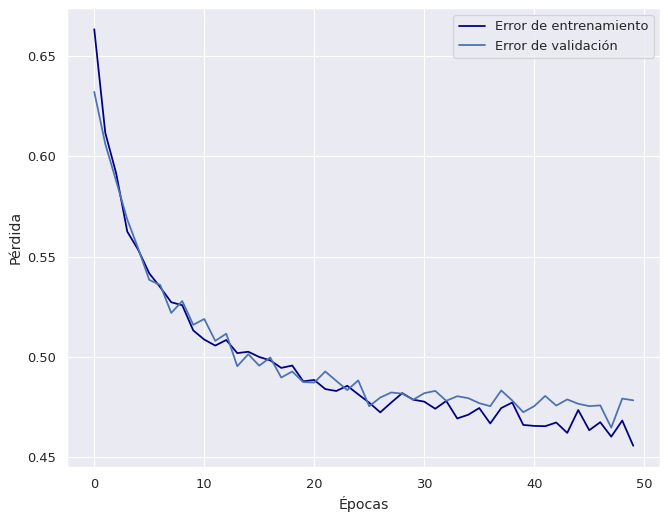

In [67]:
plt.rcParams['figure.dpi'] = 85
plt.figure(figsize=(9, 7))

plt.plot(history.history_['loss'], color='navy', label='Error de entrenamiento')     # en keras.wrapped es .history['loss']
plt.plot(history.history_['val_loss'], color='b', label='Error de validación')       # en scikeras es .history_['loss']
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Al graficar la pérdida en función de las épocas se observa un decaimiento en los errores de entrenamiento y validación, indicando que el modelo está aprendiendo. El corte se produce en la época 50 ya que luego la curva en el conjunto de validación comienza a crecer, indicando un sobreajuste.

# IV) **Resultados y conclusiones finales**

Graficando la curva ROC de cada uno de los modelos se tiene un mapa de cómo es el rendimiento de los modelos. Además se elabora una tabla del error cuadrático medio (MSE), entropía binaria cruzada (BCE), área bajo la curva ROC (AUC), accuracy y recall clase 1 de cada estimador.

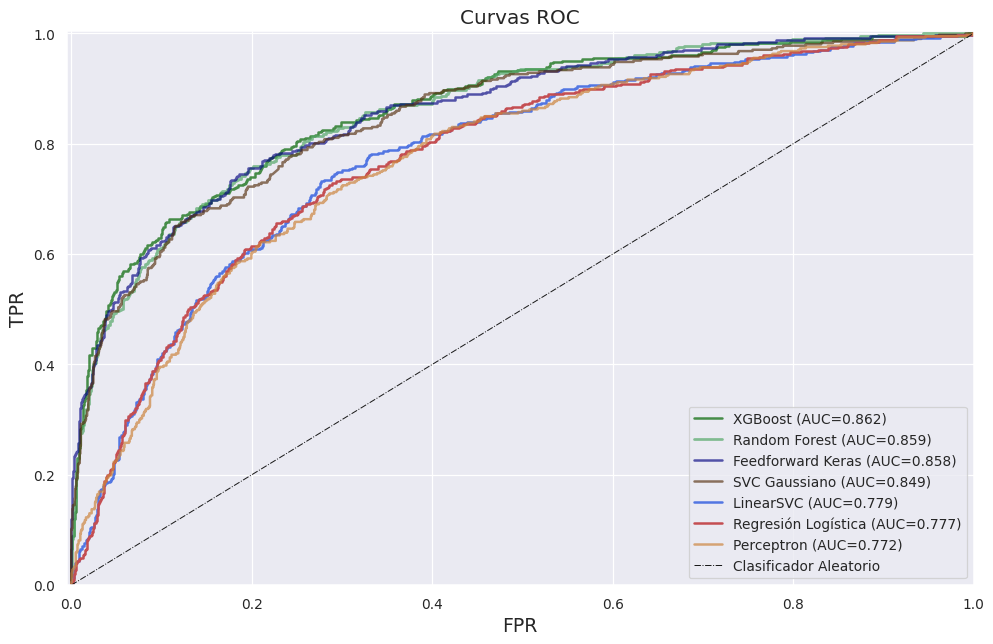

In [73]:
plt.rcParams['figure.dpi'] = 90
plt.figure(figsize=(13, 8))

# XGBoost
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', linewidth=2, zorder=1, alpha=0.7, label=f'XGBoost (AUC={auc_xgb:.3f})')

# Random Forest
plt.plot(fpr_rf, tpr_rf, color='g', linewidth=2.2, zorder=1, alpha=0.7, label=f'Random Forest (AUC={auc_rf:.3f})')

# Red Feedforward
plt.plot(fpr_keras, tpr_keras, color='navy', linewidth=2, zorder=1, alpha=0.65, label=f'Feedforward Keras (AUC={auc_keras:.3f})')

# SVC Gaussiano
plt.plot(fpr_rbf, tpr_rbf, color='#562F0E', linewidth=2, zorder=1, alpha=0.65, label=f'SVC Gaussiano (AUC={auc_rbf:.3f})')

# LinearSVC
plt.plot(fpr_lsvc, tpr_lsvc, color='royalblue', linewidth=2, zorder=1, alpha=0.9, label=f'LinearSVC (AUC={auc_lsvc:.3f})')

# Regresión Logística
plt.plot(fpr_rl, tpr_rl, color='r', linewidth=2, zorder=1, alpha=1, label=f'Regresión Logística (AUC={auc_rl:.3f})')

# Perceptron
plt.plot(fpr_perc, tpr_perc, color='peru', linewidth=2, zorder=1, alpha=0.7, label=f'Perceptron (AUC={auc_perc:.3f})')

# Aleatorio
plt.plot([0, 1], [0, 1], 'k-.', linewidth=0.8, label='Clasificador Aleatorio')

plt.xlim([-0.005, 1])
plt.ylim([0, 1.005])
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)

plt.legend(loc='lower right', frameon=True, fontsize=11)
plt.title('Curvas ROC', fontsize=16)
plt.show()

In [71]:
metricas = [
    ['Regresión Logística', acc_rl, rec_rl, mse_rl, bce_rl, auc_rl, optimal_threshold_rl],
    ['Random Forest', acc_rf, rec_rf, mse_rf, bce_rf, auc_rf, optimal_threshold_rf],
    ['XGBoost', acc_xgb, rec_xgb, mse_xgb, bce_xgb, auc_xgb, optimal_threshold_xgb],
    ['Perceptron', acc_perc, rec_perc, mse_perc, bce_perc, auc_perc, optimal_threshold_perc],
    ['LinearSVC', acc_lsvc, rec_lsvc, mse_lsvc, bce_lsvc, auc_lsvc, optimal_threshold_lsvc],
    ['SVC gaussiano', acc_rbf, rec_rbf, mse_rbf, bce_rbf, auc_rbf, optimal_threshold_rbf],
    ['Red Feedforward', acc_keras, rec_keras, mse_keras, bce_keras, auc_keras, optimal_threshold_keras]
]

pd.options.display.float_format = '{:.2f}'.format

df_metricas = pd.DataFrame(metricas, columns=['Modelo', 'Accuracy', 'Recall', 'MSE', 'BCE', 'AUC', 'Umbral']).rename(columns={'Modelo': ' '}).set_index(' ')
df_metricas

,Accuracy,Recall,MSE,BCE,AUC,Umbral
,,,,,,
Regresión Logística,0.71,0.73,0.20,0.58,0.78,0.49
Random Forest,0.79,0.76,0.16,0.48,0.86,0.51
XGBoost,0.76,0.81,0.15,0.46,0.86,0.46
Perceptron,0.70,0.72,0.20,0.60,0.77,0.49
LinearSVC,0.72,0.73,0.20,0.58,0.78,0.50
SVC gaussiano,0.83,0.66,0.16,0.48,0.85,0.65
Red Feedforward,0.79,0.76,0.16,0.48,0.86,0.53


Como se observa de la gráfica, existen dos grupos perfectamente separados y coincidentes, por un lado, con los modelos más complejos (y de mejores resultados) y, por otro, con los más simples (y resultados inferiores).

Centrándonos en la tabla y teniendo en cuenta que en este problema se intenta maximizar el recall de la clase 1, la métrica accuracy se deja en un segundo plano. En base a esto podemos argumentar que tanto XGBoost, Random Forest y la red son los mejores estimadores (los dos últimos con resultados exactamente iguales). Dado que el primero de estos tiene un alto recall (aunque menor accuracy), con errores más pequeños e igual AUC, se podría considerar a XGBoost levemente por encima en la tríada. SVC gaussiano tiene buenas métricas en su conjunto pero tiene una carencia importante a la hora de clasificar correctamente la clase 1, motivo por el que se lo relega a una cuarta posición.

Por último se encuentra el grupo compuesto por LinearSVC, Regresión Logística y Perceptron, cuyos resultados reflejan similitudes en el rendimiento. Un aspecto interesante sobre el Perceptron, a pesar de ser el más deficiente de la lista, es el hecho de que exista un hiperplano 15-dimensional en donde los datos son separables con un recall del 72% en la clase 1 y accuracy de 70%, lo cual es bastante sorprendente.

De los puntos de corte determinados por las curvas ROC, estos son bastante próximos al valor por defecto (0.5), a excepción del SVC gaussiano que traslada el umbral significativamente hacia la derecha (0.65).

Por último advertir que un solo estimador logró superar el 80% en el recall. Esto puede ser un indicio de que a la base le falta información relevante que, ya sea por carencias del banco o por ser información sensible, no se encuentra disponible, limitando el desempeño de los modelos. Esta afirmación puede respaldarse mediante la matriz de correlación, ya que la misma no reveló una clara dependencia entre las variables exógenas y la variable objetivo.